# Extracting Zeisel's Clusters

Zeisel et al clustered 3005 mouse brain cells into 9 major categories and 47 total subcategories. The purpose of this notebook is to extract visualize and process cells corresponding to a subset of these labels. <br>
1. From a set of desired labels, extract the corresponding rows in the data matrix, columns and rows of the distance matrix, and rows of the label matrix.
2. Spectral clustering and t-SNE on these truncated matrices. 
3. After selecting cells, run tophat + cufflinks to obtain a gene expression matrix (mouse transcriptome as ref).

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
from sklearn.decomposition import NMF
from sklearn.decomposition import PCA
from sklearn import manifold
from sklearn import cluster
import sklearn.metrics
from sklearn.metrics.pairwise import pairwise_distances
from scipy.stats import entropy
from numpy.linalg import pinv
import operator
import itertools
import networkx as nx
from networkx.algorithms import bipartite
from sklearn.cluster.bicluster import SpectralCoclustering
from sklearn.cluster import AgglomerativeClustering
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix
from scipy.cluster.hierarchy import *
import scipy.spatial.distance as ssd
import scipy
import colorsys

In [350]:
# Functions that are helpful for analysis

# obtain labels via spectral clustering
def jz_spectral(X,k,D):
    # Compute pairwise distances
    #D = pairwise_distances(X,metric=dist_funct,n_jobs=nj)
    if D[1,1] < 1: D = np.exp(-D**2) # Convert distance to similarity matrix
    spectral = cluster.SpectralClustering(n_clusters=k,affinity='precomputed')
    spectral.fit(D)
    labels = spectral.labels_
    return labels

# Distance metrics (input: X with m samples, output: m-by-m distance matrix)
def shannon_jensen(p, q):
    m=0.5*p+0.5*q
    p = np.transpose(p[p > 0])
    q = np.transpose(q[q > 0])
    m = np.transpose(m[m > 0])
    return np.sqrt(entropy(m)-0.5*entropy(q)-0.5*entropy(p))

# obtain two major directions from t-SNE
def tSNE_pairwise(D):
    tsne = manifold.TSNE(n_components=2, random_state=0, metric='precomputed', n_iter=2000);
    X_tsne = tsne.fit_transform(D);
    return X_tsne

# Plot function with colors corresponding to labels (first two columns of X)
def jz_plot(X,labels):
    unique_labels = np.unique(labels)
    plt.figure(figsize=(15,10))
    for label in unique_labels:
        ind = np.squeeze(labels == label)
        plt.scatter(X[ind,0],X[ind,1],c=np.random.rand(3))

#Compute the error rates of two classification schemes.
#Rather than going over m! possibilities where m is the number of classes
#this uses the heuristic of comparing the i th largest cluster of on labeling scheme
#with the i th largest cluster of the other labelling scheme
def compare_labels(label1, label2):
    # quality control.. make sure inputs are np arrays and their lengths are equal
    nplabel1=np.array(label1)
    nplabel2=np.array(label2)
    assert len(label1)==len(label2)
    unique_labels1=np.unique(nplabel1)
    unique_labels2=np.unique(nplabel2)
    # Create two dictionaries that count the number of each unique label in the two label sets
    num_entries1={}
    num_entries2={}
    for label in unique_labels1:
        num_entries1[label] = len(nplabel1[nplabel1==label])
    for label in unique_labels2:
        num_entries2[label] = len(nplabel2[nplabel2==label])
    sorted_label1 = sorted(num_entries1.items(), key=operator.itemgetter(1))
    sorted_label2 = sorted(num_entries2.items(), key=operator.itemgetter(1))
    # Find and return the sum of the differences between the ith largest labelings for label1, label2
    difference=0
    for index in xrange(len(sorted_label1)):
         set1= set(np.flatnonzero(nplabel1==sorted_label1[index][0]))
         set2= set(np.flatnonzero(nplabel2==sorted_label2[index][0]))
         difference+=len(set1.symmetric_difference(set2))
    return difference/2

#gets max weight matching of a biparetite graph with row_label x column_label
#where the weight is given by the weight_matrix
def get_max_wt_matching(row_label,column_label, weight_matrix):
    # Create a bipartite graph where each group has |unique labels| nodes
    G = nx.complete_bipartite_graph(len(row_label), len(column_label))
    # Weight each edge by the weight in weight  matrix.. 
    for u,v in G.edges():
        G[u][v]["weight"]=weight_matrix[u,v-len(row_label)]
    # Perform weight matching using Kuhn Munkres
    H=nx.max_weight_matching(G)
    max_wt=0
    for u,v in H.items():
        max_wt+=G[u][v]["weight"]/float(2)
    return max_wt

#Plot heatmap
def get_heatmap(data_matrix, row_labels, column_labels, ttl):
    plt_shape = (int(data_matrix.shape[0]*.5),data_matrix.shape[1]*.5)
    fig, ax = plt.subplots(figsize=plt_shape)
    heatmap = ax.pcolor(data_matrix, cmap=plt.cm.Blues)
    # put the major ticks at the middle of each cell
    ax.set_xticks(np.arange(data_matrix.shape[0])+0.5, minor=False)
    ax.set_yticks(np.arange(data_matrix.shape[1])+0.5, minor=False)
    # want a more natural, table-like display
    ax.invert_yaxis()
    ax.xaxis.tick_top()
    ax.set_xticklabels(row_labels, minor=False)
    ax.set_yticklabels(column_labels, minor=False)
    plt.title(ttl+"\n",fontsize=14)
    plt.colorbar(heatmap)
    plt.show()
    
def analyse_labeling_schemes(label1, label2):
    # quality control.. make sure inputs are np arrays and their lengths are equal
    nplabel1=np.array(label1)
    nplabel2=np.array(label2)
    assert len(label1)==len(label2)
    unique_labels1=np.unique(nplabel1)
    unique_labels2=np.unique(nplabel2)
    # Create two dictionaries. Each will store the indices of each label
    entries1={}
    entries2={}
    for label in unique_labels1:
        entries1[label] = set(np.flatnonzero((nplabel1==label)))
    for label in unique_labels2:
        entries2[label] = set(np.flatnonzero((nplabel2==label)))
    # Create an intersection matrix which counts the number of entries that overlap for each label combination
    intersection_matrix=np.zeros((len(unique_labels1),len(unique_labels2)))
    for ind1,ind2 in itertools.product(range(len(unique_labels1)),range(len(unique_labels2))):
        intersection_matrix[ind1,ind2]=len(entries1[unique_labels1[ind1]].
                                               intersection(entries2[unique_labels2[ind2]]))
    # Plot a heatmap of the intersection matrix
   
    fig, ax = plt.subplots(figsize=(int(intersection_matrix.shape[1]),int(intersection_matrix.shape[0]*0.5)))
    heatmap=ax.pcolor((intersection_matrix).transpose(),cmap=plt.cm.bone_r)
    ax.set_xticks(np.arange(intersection_matrix.shape[0])+0.5, minor=False)
    ax.set_yticks(np.arange(intersection_matrix.shape[1])+0.5, minor=False)
    ax.invert_yaxis()
    ax.xaxis.tick_top()
    ax.set_xticklabels(unique_labels1, minor=False,fontsize=15)
    ax.set_yticklabels(unique_labels2, minor=False,fontsize=40)
    plt.colorbar(heatmap)
    plt.show()
    
    
    get_heatmap(intersection_matrix, unique_labels1, unique_labels2, 
                'Unnormalised heatmap of intersection of labels')
    #get_heatmap(intersection_matrix/intersection_matrix.sum(axis=0), 
     #           unique_labels1, unique_labels2, 
     #          'Heatmap of intersection of labels normalised by labels along columns')
    #get_heatmap((intersection_matrix.T/intersection_matrix.sum(axis=1)).T, 
     #           unique_labels1, unique_labels2,
     #          'Heatmap of intersection of labels normalised by labels along rows')
    # Print various error rates
    print "Error rates if best cluster index is picked row-wise : " + str(
        (1- sum(np.max(intersection_matrix, axis=0))/float(len(label1)))*100) + "%."
    print "Error rates if best cluster index is picked column-wise : " + str(
        (1- sum(np.max(intersection_matrix, axis=1))/float(len(label1)))*100) + "%."
    print "Error rates if best cluster index is picked using the Hungarian Algorithm : " + str(
        (1- get_max_wt_matching(unique_labels1,
                                unique_labels2,intersection_matrix)
         /float(len(label1)))*100) + "%."
    
def jz_analyse_labeling_schemes(label1, label2):
    # quality control.. make sure inputs are np arrays and their lengths are equal
    nplabel1=np.array(label1)
    nplabel2=np.array(label2)
    assert len(label1)==len(label2)
    unique_labels1=np.unique(nplabel1)
    unique_labels2=np.unique(nplabel2)
    # Create two dictionaries. Each will store the indices of each label
    entries1={}
    entries2={}
    for label in unique_labels1:
        entries1[label] = set(np.flatnonzero((nplabel1==label)))
    for label in unique_labels2:
        entries2[label] = set(np.flatnonzero((nplabel2==label)))
    # Create an intersection matrix which counts the number of entries that overlap for each label combination
    intersection_matrix=np.zeros((len(unique_labels1),len(unique_labels2)))
    for ind1,ind2 in itertools.product(range(len(unique_labels1)),range(len(unique_labels2))):
        intersection_matrix[ind1,ind2]=len(entries1[unique_labels1[ind1]].
                                               intersection(entries2[unique_labels2[ind2]]))
    # Print various error rates
    return (1- sum(np.max(intersection_matrix, axis=0))/float(len(label1)))*100,(1- sum(np.max(intersection_matrix, axis=1))/float(len(label1)))*100, (1- get_max_wt_matching(unique_labels1,unique_labels2,intersection_matrix)/float(len(label1)))*100  

def vn_AffinityProp(D):
    aff= cluster.AffinityPropagation(affinity='precomputed')
    labels=aff.fit_predict(D)
    return labels
# Plot function with Zeisel colors corresponding to labels (first two columns of X)
def tru_plot9(X,labels,tru_color,name_of_clustID):
    
    unique_labels = np.unique(labels)
    plt.figure(figsize=(15,10))
    for label in unique_labels:
        ind = np.squeeze(labels == label)
        plt.scatter(X[ind,0],X[ind,1],
                    c=tru_color[label.astype(int)],s=36,
                    edgecolors='gray',lw = 0.5, label=name_of_clustID[label.astype(int)])        
    plt.legend(loc='upper right',bbox_to_anchor=(1.1, 1))

In [71]:
# Load EC data
with open('/data/SS_RNA_seq/Code/sparse_eq_class.dat', 'rb') as infile:
    X_ec = pickle.load(infile)
with open('/data/SS_RNA_seq/Code/pairwise_jensen_shannon_divergence.dat', 'rb') as infile:
    D_ec = pickle.load(infile)
    
# Load gene expression data
with open('/data/SS_RNA_seq/Code/Zeisel_pairwise_gene_expression.dat','rb') as infile:
    X_gene = pickle.load(infile)
with open('/data/SS_RNA_seq/Code/pairwise_jensen_shannon_gene_expression3', 'rb') as infile:
    D_gene = pickle.load(infile)
    
# Load truth labels    
truth_9 = np.loadtxt('/data/SS_RNA_seq/Code/clustering_on_reads/Zeisel_metadata/cell_group_num_3005.txt',dtype=str)
truth_47 = np.loadtxt('/data/SS_RNA_seq/Code/clustering_on_reads/Zeisel_metadata/cell_subclass_3005.txt',dtype=str)

# Sanity check
print np.shape(X_ec)
print np.shape(D_ec)
print np.shape(X_gene)
print np.shape(D_gene)
print np.shape(truth_9)
print np.unique(truth_9)
print np.shape(truth_47)
print np.unique(truth_47)

(3005, 342812)
(3005, 3005)
(3005, 19972)
(3005, 3005)
(3005,)
['1' '2' '3' '4' '5' '6' '7' '8' '9']
(3005,)
['(none)' 'Astro1' 'Astro2' 'CA1Pyr1' 'CA1Pyr2' 'CA1PyrInt' 'CA2Pyr2'
 'Choroid' 'ClauPyr' 'Epend' 'Int1' 'Int10' 'Int11' 'Int12' 'Int13' 'Int14'
 'Int15' 'Int16' 'Int2' 'Int3' 'Int4' 'Int5' 'Int6' 'Int7' 'Int8' 'Int9'
 'Mgl1' 'Mgl2' 'Oligo1' 'Oligo2' 'Oligo3' 'Oligo4' 'Oligo5' 'Oligo6'
 'Peric' 'Pvm1' 'Pvm2' 'S1PyrDL' 'S1PyrL23' 'S1PyrL4' 'S1PyrL5' 'S1PyrL5a'
 'S1PyrL6' 'S1PyrL6b' 'SubPyr' 'Vend1' 'Vend2' 'Vsmc']


In [166]:
# Get indices for a certain subset of labels
def get_indices_for_subset(labels,subsets):
    np.random.seed(0)
    min_count = 25#min([np.sum(labels == i) for i in subsets])
    indices = []
    for label in subsets:
        # randomly choose (without replacement) samples such that sizes of labels match
        temp = np.where(labels == label)[0]
        indices.append(np.random.choice(temp,min_count,replace=False))
    return np.sort(np.concatenate(indices))

# Truncate data using subset of labels
def truncate_data(labels,subsets,X,D):
    ind = get_indices_for_subset(labels,subsets)
    return X[ind,:],D[np.ix_(ind,ind)],labels[ind]

In [167]:
# Select desired labels (put label names in "subsets")
subsets = ['3','4']
labels = truth_9
Xt_ec,  Dt_ec,  Lt_ec   = truncate_data(labels,subsets,X_ec,D_ec)
Xt_gene,Dt_gene,Lt_gene = truncate_data(np.sort(labels),subsets,X_gene,D_gene)

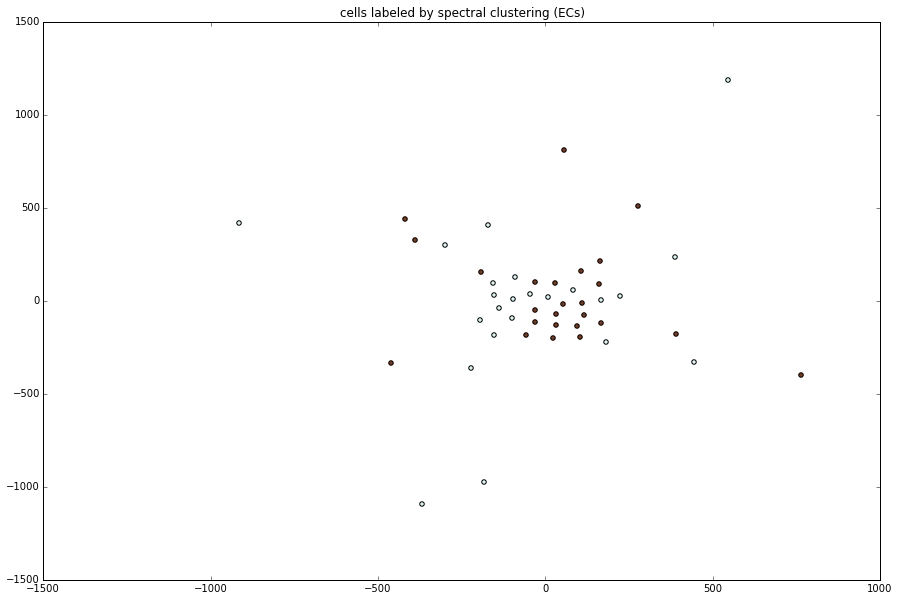

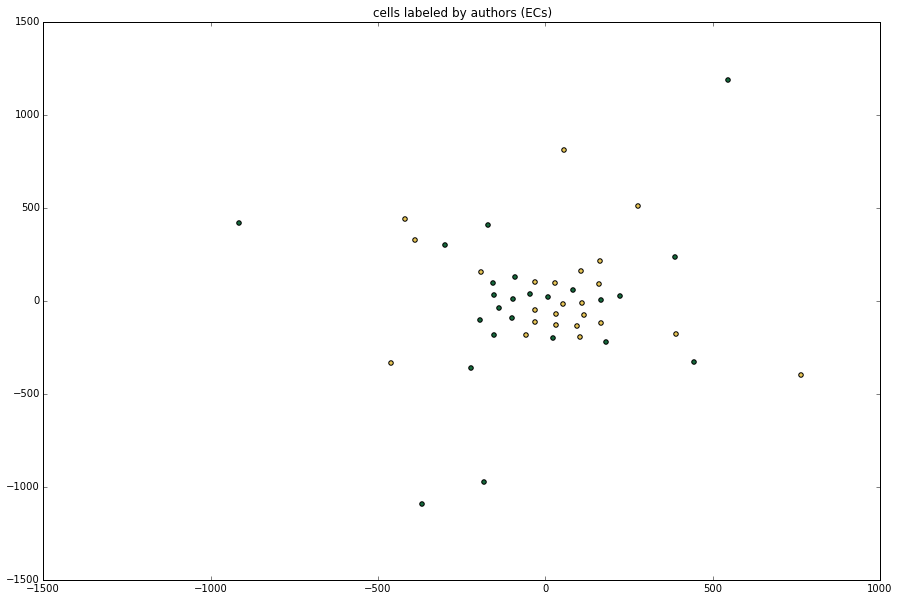

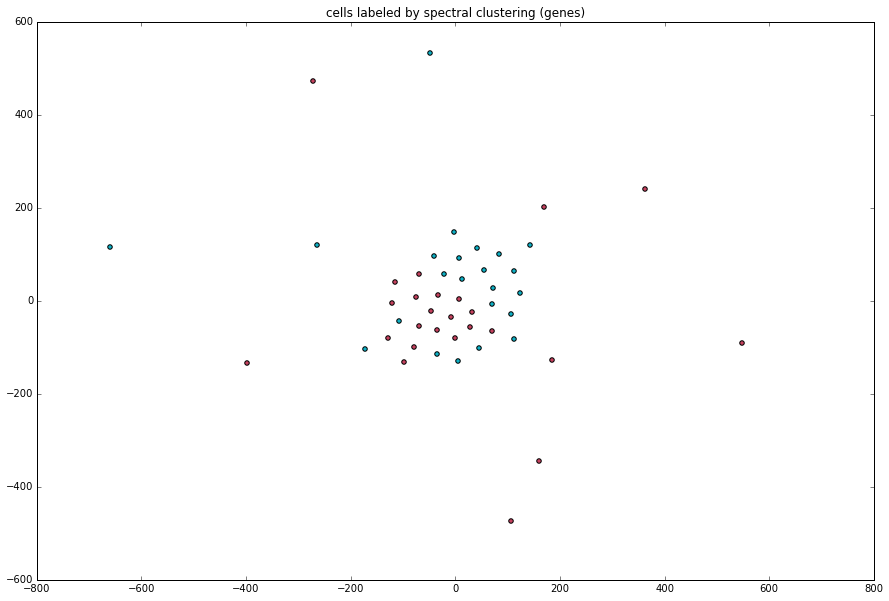

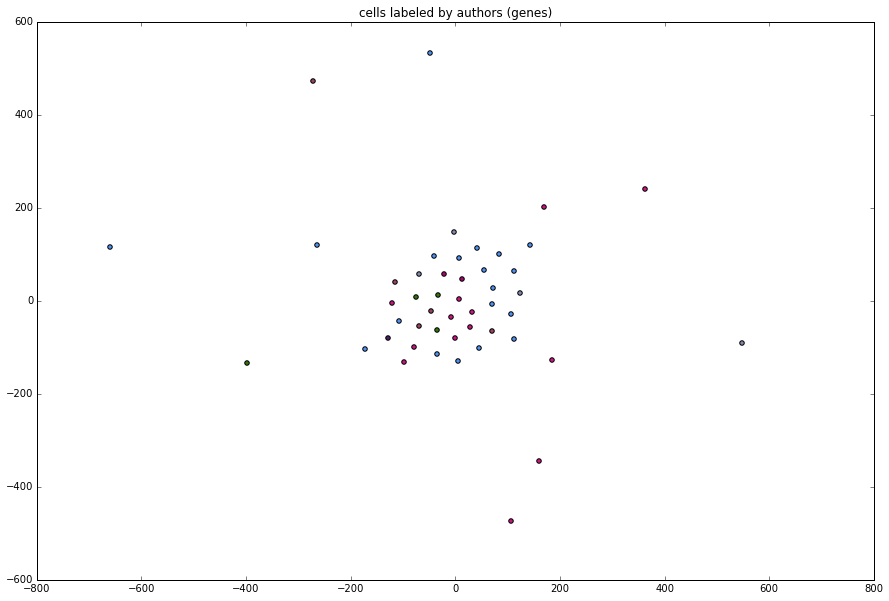

In [292]:
# Spectral clustering
%matplotlib inline
spect_labels_ec = jz_spectral(Xt_ec,len(subsets),Dt_ec)
Xt_ec_tSNE = tSNE_pairwise(Dt_ec)
jz_plot(Xt_ec_tSNE,spect_labels_ec)
plt.title('cells labeled by spectral clustering (ECs)')
jz_plot(Xt_ec_tSNE,Lt_ec)
plt.title('cells labeled by authors (ECs)')

spect_gene_labels = jz_spectral(Xt_gene,len(subsets),Dt_gene)
Xt_gene_tSNE = tSNE_pairwise(Dt_gene)
jz_plot(Xt_gene_tSNE,spect_gene_labels)
plt.title('cells labeled by spectral clustering (genes)')
jz_plot(Xt_gene_tSNE,Lt_gene)
plt.title('cells labeled by authors (genes)')


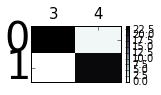

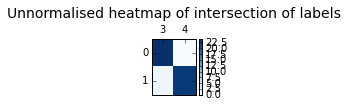

Error rates if best cluster index is picked row-wise : 2.08333333333%.
Error rates if best cluster index is picked column-wise : 2.08333333333%.
Error rates if best cluster index is picked using the Hungarian Algorithm : 2.08333333333%.


In [293]:
analyse_labeling_schemes(Lt_ec,spect_labels_ec)

# Run TopHat, Cufflinks on selected cells 

In [181]:
import os
files = np.array(sorted(os.listdir('/data/SS_RNA_seq/Zeisel/read_data_3005')))
selected = files[get_indices_for_subset(labels,subsets)]
print selected

['SRR1544919.fastq.gz' 'SRR1545031.fastq.gz' 'SRR1545067.fastq.gz'
 'SRR1545107.fastq.gz' 'SRR1545111.fastq.gz' 'SRR1545145.fastq.gz'
 'SRR1545287.fastq.gz' 'SRR1545324.fastq.gz' 'SRR1545359.fastq.gz'
 'SRR1545593.fastq.gz' 'SRR1545651.fastq.gz' 'SRR1545731.fastq.gz'
 'SRR1546122.fastq.gz' 'SRR1546178.fastq.gz' 'SRR1546190.fastq.gz'
 'SRR1546444.fastq.gz' 'SRR1546513.fastq.gz' 'SRR1546530.fastq.gz'
 'SRR1546619.fastq.gz' 'SRR1546643.fastq.gz' 'SRR1546665.fastq.gz'
 'SRR1546784.fastq.gz' 'SRR1546831.fastq.gz' 'SRR1546843.fastq.gz'
 'SRR1546901.fastq.gz' 'SRR1546964.fastq.gz' 'SRR1546993.fastq.gz'
 'SRR1547069.fastq.gz' 'SRR1547089.fastq.gz' 'SRR1547179.fastq.gz'
 'SRR1547187.fastq.gz' 'SRR1547240.fastq.gz' 'SRR1547241.fastq.gz'
 'SRR1547241.fastq.gz' 'SRR1547244.fastq.gz' 'SRR1547295.fastq.gz'
 'SRR1547296.fastq.gz' 'SRR1547355.fastq.gz' 'SRR1547384.fastq.gz'
 'SRR1547436.fastq.gz' 'SRR1547533.fastq.gz' 'SRR1547568.fastq.gz'
 'SRR1547568.fastq.gz' 'SRR1547661.fastq.gz' 'SRR1547668.fastq

In [230]:
# Run TopHat on each of selected cells
import multiprocessing as mp

def run_tophat(flname):
    index = '/data/SS_RNA_seq/Zeisel/reference_transcriptome/Mus_musculus.GRCm38.rel79.cdna.all'
    num = flname.split('/')[4].split('sample')[1]
    THout = '/data/SS_RNA_seq/Zeisel/tophat_subsample' + num + '/' + flname.split('/')[5].split('.')[0]
    os.system('mkdir -p ' + THout)
    THcmd = 'tophat -o ' + THout + ' ' + index + ' ' + flname
    os.system(THcmd)
    CLcmd = 'cufflinks -o ' + THout + ' ' + THout + '/accepted_hits.bam'
    os.system(CLcmd)

#for i in ['1','5','10','30','50','70','90']:    
for i in ['10']:
    fldir = '/data/SS_RNA_seq/Zeisel/read_data_subsample'+i
    files = [fldir+'/'+f for f in selected]
    pool = mp.Pool(processes = 50)
    pool.map(run_tophat,files)

In [348]:
# Obtain gene expression matrix for each of the samples sizes

#for i in ['1','5','10','30','50','70','90']:    
for i in ['10']:
    dict = {}
    files = np.array(sorted(os.listdir('/data/SS_RNA_seq/Zeisel/tophat_subsample'+i)))
    
    # First pass: get all unique genes
    count = 0
    for f in files:
        fo = open('/data/SS_RNA_seq/Zeisel/tophat_subsample'+i+'/'+f+'/transcripts.gtf')
        for line in fo:
            temp = line.split('\t')
            if temp[2] == 'transcript':
                key = temp[0]
                if key not in dict: 
                    dict[key] = count
                    count += 1
    
    # Second pass: Count nubmer of unique genes
    gene_abundances = np.zeros([len(files),len(dict)]);
    cell_ind = 0
    for f in files:
        fo = open('/data/SS_RNA_seq/Zeisel/tophat_subsample'+i+'/'+f+'/transcripts.gtf')
        for line in fo:
            temp = line.split('\t')
            if temp[2] == 'transcript':
                key = temp[0]
                temp = temp[8].split(';')
                quant = float(temp[2][7:-1])
                gene_abundances[cell_ind,dict[key]] += quant
        cell_ind += 1

SRR1546964
SRR1547241


In [351]:
# Generate distance matrix
D_gene = pairwise_distances(gene_abundances,metric=shannon_jensen)

# Plot accuracy curve using gene abundances and equivalence classes

In [360]:
# First, for equivalence classes
ind = np.unique(get_indices_for_subset(labels,subsets))

scores_ec = []
for i in ['1','5','10','30','50','70','90']: 
    with open('/data/SS_RNA_seq/Code/sparse_eq_class_Zeisel_subsample'+i+'.dat') as infile:
        Xs = pickle.load(infile)
    with open('/data/SS_RNA_seq/Code/clustering_on_reads/Zeisel_SJ_subsample'+i+'.dat','rb') as infile:
        Ds = pickle.load(infile)
    Xs = Xs[ind,:]
    Ds = Ds[np.ix_(ind,ind)]
    labels_s = jz_spectral(Xs,len(subsets),Ds)
    a,b,c = jz_analyse_labeling_schemes(Lt_ec,labels_s)
    scores_ec.append(c)
a,b,c = jz_analyse_labeling_schemes(Lt_ec,spect_labels_ec)
scores_ec.append(a)

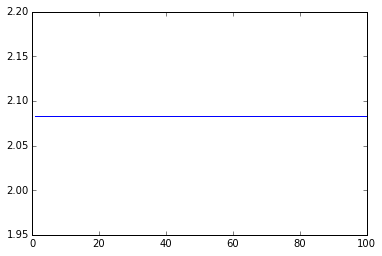

In [361]:
%matplotlib inline  
plt.plot([1,5,10,30,50,70,90,100],scores_ec)
plt.show()

In [355]:
# Spectral clustering on subsampled gene abundance matrix
labels_s = jz_spectral(gene_abundances,len(subsets),D_gene)
a,b,c = jz_analyse_labeling_schemes(Lt_ec,labels_s)
print c

45.8333333333
